In [1]:
import utils
import keras
import model01
import datasets
import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
# FILENAME = './output/MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5-200-0.6926.hdf5'
#FILENAME = './output/MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5-200-0.6890.hdf5'
FILENAME = './output/MLPModel01_20170418_1151_EURUSD_DS3_20092014_LA1_F99_C2_L100_100_100_DO0.5-1005-0.6913.hdf5'

In [3]:
model = keras.models.load_model(FILENAME)

In [4]:
#pc = model01.ProgressCallback.load('MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5')
#pc = model01.ProgressCallback.load('MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5')
pc = model01.ProgressCallback.load('MLPModel01_20170418_1151_EURUSD_DS3_20092014_LA1_F99_C2_L100_100_100_DO0.5')


loading from file: ./output/MLPModel01_20170418_1151_EURUSD_DS3_20092014_LA1_F99_C2_L100_100_100_DO0.5.npz


In [10]:
# load test dataset
lookahead=1
dataset = 'DS3'
window=25
sym='EURUSD'
year=2016
X_test, Y_test, prices_test  = datasets.load(datasets.filename(dataset, lookahead, window, sym, year))

test: f1-score: 0.519, mean future return: 0.024 bps, annualized future return 1.475


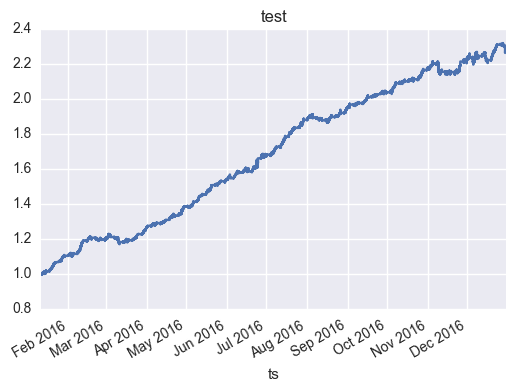

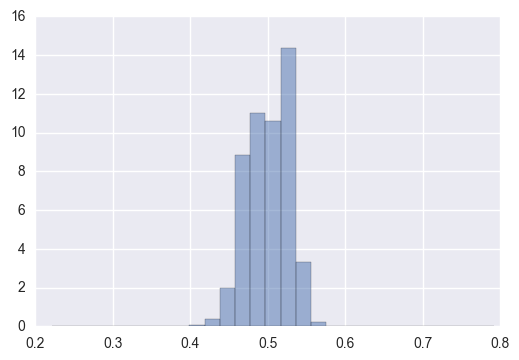

[[82352 89514]
 [75875 96686]]


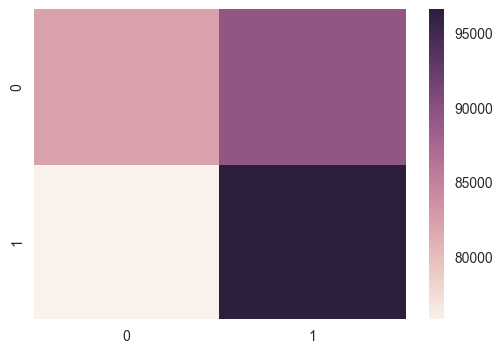

In [11]:
Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024).ravel()
metrics.performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred, cum_return_plot=True, histogram=True, heatmap=True)

-----------------------------------------


!! Idea: assess performance of 1 minute prediction over next n periods,  
e.g. by average signal, ewma signal.
also by average of prediction, versus avearage of category.
i.e. before and after rounding to category.

    Versus predicting on n periods ahead directly.
    
    Increase N to point of being potentially tradeable.
    
    

In [13]:
Y_test_pred

array([ 0.48084542,  0.48715833,  0.51415962, ...,  0.51044405,
        0.47974336,  0.51881605], dtype=float32)

In [9]:
# idea: what is mean num samples that return stays in same direction...

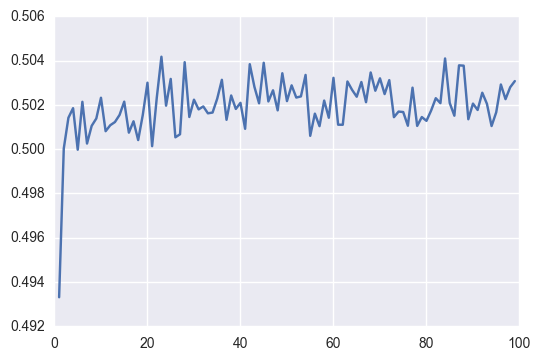

In [12]:
# this is measure of autocorrelation of direction.
direction = np.sign(prices_test.pct_change() - prices_test.pct_change().mean()).dropna()
df = pd.DataFrame({'direction':direction})
N = 100
i_s = []
res = []
for i in np.arange(1,N,1):
    df['same'] = df.direction.shift(i) == df.direction
    res.append(df.same.tail(-N).mean(skipna=False)) # careful to ensure that we discard same number of samples for each i.
    i_s.append(i)
res
plt.plot(i_s, res)

In [11]:
direction.mean()

-0.084676406388691949

In [12]:
(direction.shift(1000) == direction).mean()

0.50300900468377541

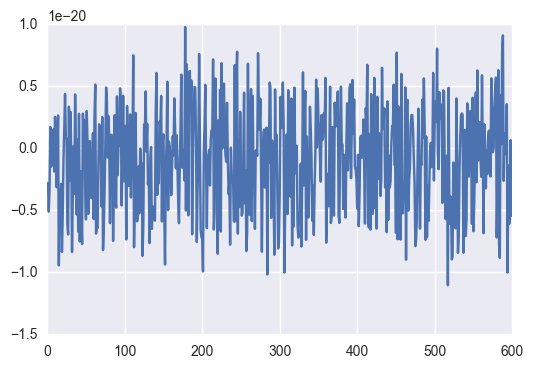

In [14]:
# now try same on returns themselves
returns = (prices_test.pct_change() - prices_test.pct_change().mean()).dropna()

df = pd.DataFrame({'returns':returns})
N = 600
i_s = []
res = []


for i in np.arange(1,N,1):
    offset = df.returns.shift(i).tail(-N).mean() + df.returns.tail(-N).mean()
    #print ("offset:",offset)
    df['similarity'] = df.returns.shift(i) + df.returns - offset
    res.append(df.similarity.tail(-N).mean(skipna=False)) # careful to ensure that we discard same number of samples for each i.
    i_s.append(i)
res
plt.plot(i_s, res)

In [15]:
def aggregated_predicted_future_return(prices, prediction, agg_period, mode='sma', demean=True):

    predicted_class = utils.prediction_to_category2(prediction)
    fut_returns = utils.future_return(prices, agg_period).fillna(0)
    if demean:
        fut_returns = fut_returns - fut_returns.mean()

    predicted_class = predicted_class.ravel()

    if mode == 'sma':
        agg = pd.Series(predicted_class).rolling(window=agg_period)
    elif mode == 'ewm':
        agg = pd.Series(predicted_class).ewm(com=agg_period)
    else:
        raise ValueError("Unexpected mode: {}. Expected 'sma' or 'ewm'".format(mode))
    agg_predicted_class = agg.mean().values.astype(int)

    l = len(fut_returns)
    mult = np.zeros(l)
    mult[agg_predicted_class == 0] = -1
    mult[agg_predicted_class == 1] = 1
    return fut_returns * mult



/Users/andy/.virtualenvs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


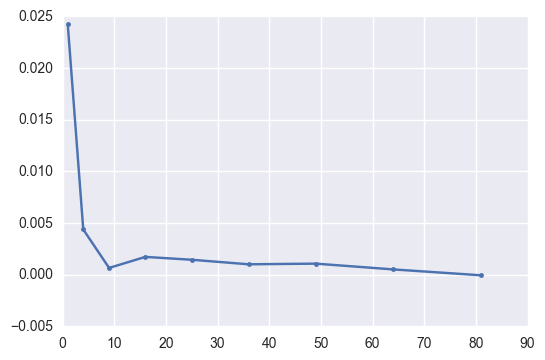

In [16]:
i_s = []
frsma = []
frewma = []
for ii in np.arange(0,10,1):
    i= ii*ii
    i_s.append(i)
    fut_ret_sma = aggregated_predicted_future_return(
        prices=prices_test, prediction=Y_test_pred, agg_period=i, mode='sma').mean() *1e4
    
    
    # scale by time...
    frsma.append(fut_ret_sma / i)
    
#     fut_ret_ewma = aggregated_predicted_future_return(
#         prices=prices_test, prediction=Y_test_pred, agg_period=i, mode='ewm').mean() *1e4
#     frewma.append(fut_ret_ewma)

plt.plot(i_s, frsma,'.-')
#plt.plot(i_s, frewma,'.-')
    

??? why are perf charts below different to fut return charts from performance report.????

In [17]:
def perf(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    cats = utils.prediction_to_category2(preds)
    # turn true/false into +1/-1
    signs = cats*2 -1 
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [18]:
def perf2(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = preds - 0.5
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [19]:
def perf3(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = (preds - 0.5)
    signs = np.tanh(signs/2)
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [20]:
print perf(Y_test_pred, fut_return_test).sum()
print perf2(Y_test_pred, fut_return_test).sum()
print perf3(Y_test_pred, fut_return_test).sum()

NameError: name 'fut_return_test' is not defined

In [ ]:
perf(Y_test_pred, fut_return_test).cumsum().plot(label='perf')
perf2(Y_test_pred, fut_return_test).cumsum().plot(label='perf2')
perf3(Y_test_pred, fut_return_test).cumsum().plot(label='perf3')
plt.legend()

-----------------------------------

## Control

In [22]:
X_control, Y_control, prices_control = datasets.prepare_dataset1(df=datasets.random_ohlc(100000),lookahead=1, window=60)

In [23]:
X_test.describe()

,open-0,high-0,low-0,open-1,high-1,low-1,close-1,open-2,high-2,low-2,...,low-328,close-328,open-365,high-365,low-365,close-365,open-404,high-404,low-404,close-404
count,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,...,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000,358259.000000
mean,0.000243,-0.002332,0.003090,0.000359,-0.001654,0.002210,0.000184,0.000447,-0.001301,0.002000,...,0.002393,0.001797,0.002134,0.001548,0.002705,0.002111,0.002293,0.001730,0.002841,0.002271
std,0.997288,0.998029,0.995869,0.997396,0.996756,0.996800,0.993620,0.998185,0.997982,0.998023,...,1.016826,1.016878,1.018205,1.018258,1.018104,1.018164,1.019834,1.019896,1.019714,1.019786
min,-41.474343,-0.930162,-48.449959,-42.989812,-46.076190,-46.715843,-50.304307,-38.871577,-40.527500,-40.423925,...,-6.548616,-6.587477,-5.850172,-5.889537,-5.862776,-5.904807,-6.156222,-6.138335,-6.180743,-6.224008
25%,-0.421736,-0.638671,-0.314112,-0.457532,-0.470333,-0.410545,-0.431293,-0.463604,-0.472507,-0.432892,...,-0.574393,-0.574826,-0.584074,-0.584088,-0.583156,-0.583626,-0.599440,-0.599953,-0.598523,-0.598663
50%,0.000894,-0.321009,0.318917,0.002769,-0.131342,0.133746,0.003081,0.003141,-0.088433,0.091136,...,-0.009924,-0.011752,-0.013365,-0.016358,-0.011683,-0.013712,-0.012754,-0.014517,-0.010934,-0.012647
75%,0.418290,0.306869,0.640550,0.452806,0.403528,0.475575,0.424483,0.460131,0.427756,0.475386,...,0.572985,0.570686,0.578230,0.577719,0.579499,0.579204,0.578660,0.577812,0.579469,0.578631
max,37.907315,47.356102,0.988910,30.819933,35.518067,25.515586,37.606508,27.256585,33.672143,25.613893,...,7.109565,7.157105,7.397889,7.416599,7.411901,7.439186,7.792148,7.759010,7.799253,7.781988


In [24]:
X_control.describe()

,open-0,high-0,low-0,open-1,high-1,low-1,close-1,open-2,high-2,low-2,...,low-58,close-58,open-59,high-59,low-59,close-59,open-60,high-60,low-60,close-60
count,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,...,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000,87942.000000
mean,-0.000252,-0.000535,-0.000631,-0.000823,-0.001040,-0.001123,-0.000937,-0.001202,-0.001378,-0.001440,...,-0.008087,-0.008048,-0.008116,-0.008142,-0.008171,-0.008134,-0.008201,-0.008228,-0.008257,-0.008218
std,0.999745,0.999181,0.999480,1.000315,1.000519,1.000535,1.000863,1.000414,1.000699,1.000825,...,1.006956,1.007024,1.007079,1.007095,1.007009,1.007078,1.007124,1.007150,1.007057,1.007130
min,-4.051221,-0.994023,-6.008138,-4.138748,-4.178513,-4.446403,-4.232589,-4.078309,-3.824861,-4.173907,...,-3.833223,-3.793165,-3.727789,-3.790899,-3.718836,-3.795069,-3.618079,-3.699954,-3.665389,-3.674181
25%,-0.676693,-0.955503,-0.576814,-0.671705,-0.686856,-0.658281,-0.676680,-0.677463,-0.681950,-0.675575,...,-0.694715,-0.693806,-0.695007,-0.696541,-0.693972,-0.694844,-0.694707,-0.696035,-0.696194,-0.694622
50%,-0.003718,-0.252288,0.250179,-0.002745,-0.022619,0.018809,-0.006797,-0.000351,-0.008603,0.008792,...,-0.014688,-0.015923,-0.015188,-0.016323,-0.016093,-0.016535,-0.016198,-0.015538,-0.015348,-0.016737
75%,0.669365,0.577837,0.950675,0.675012,0.662216,0.678151,0.672482,0.672727,0.668200,0.681421,...,0.673270,0.673617,0.672750,0.674893,0.673268,0.672685,0.672225,0.673164,0.673209,0.671506
max,4.561608,6.610925,0.984947,4.368036,4.722748,3.956653,4.126067,4.245712,4.368483,4.043057,...,3.627796,3.689760,3.698015,3.642184,3.595383,3.670816,3.490073,3.562372,3.430840,3.638690


In [25]:
Y_control_pred = model.predict(X_control.as_matrix(), batch_size=1024)
Y_control_pred_class = utils.prediction_to_category2(Y_control_pred)
metrics.performance_report("control",  prices_control,  lookahead, Y_control, Y_control_pred_class)

ValueError: Error when checking : expected dense_input_1 to have shape (None, 99) but got array with shape (87942, 243)

In [ ]:
(fut_return_control.ix[~Y_control_pred_class[:,0]]+1).mean() - fut_return_control.mean() - 1